## Environment Setup

In [ ]:
# !nvidia-smi

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/KenzaB27/segmentation-of-pelvic-bone.git
%cd /content/segmentation-of-pelvic-bone/src

In [ ]:
!pip install SimpleITK

In [ ]:
!git pull

In [47]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import SimpleITK as sitk
import analysis as ana
import numpy as np 
import importlib

import tensorflow as tf 
tfk = tf.keras
tfkl = tfk.layers

In [58]:
PATH = "/content/drive/My Drive/KTH/HL2027/"
DATA_PATH = PATH +'data/'

## Load Data

In [50]:
X_train_3C = np.load(DATA_PATH + "train_X_3C.npy")
y_train = np.load(DATA_PATH + "train_y.npy")

X_train, X_val, y_train, y_val = train_test_split(X_train_3C, y_train, test_size=0.15, random_state=42, stratify=y_train)
print(f"X train shape:{X_train.shape}, y train shape:{y_train.shape} ")
print(f"X val shape:{X_val.shape}, y val shape:{y_val.shape} ")

X train shape:(729, 512, 512, 3), y train shape:(729,) 
X val shape:(129, 512, 512, 3), y val shape:(129,) 


## Inception V3 

In [60]:
input = tfkl.Input([None, None, 3], dtype = tf.int16)
x = tf.cast(input, tf.float32)
x = tfk.applications.inception_v3.preprocess_input(x)
inception_model = tfk.applications.InceptionV3(weights="imagenet", include_top=False, pooling="max")
inception_output = inception_model(x)
hidden_layer = tfkl.Dense(512, activation='relu')(inception_output)
hl_reg = tfkl.Dropout(0.2)(hidden_layer)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(hl_reg)
model = tf.keras.models.Model(inputs=input, outputs=output_layer)

In [61]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
tf.cast_6 (TFOpLambda)       (None, None, None, 3)     0         
_________________________________________________________________
tf.math.truediv_6 (TFOpLambd (None, None, None, 3)     0         
_________________________________________________________________
tf.math.subtract_6 (TFOpLamb (None, None, None, 3)     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_12 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0   

### Training 

In [62]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
inception_model.trainable = False
for layer in inception_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-3)
model.compile(optimizer="adam", loss='binary_crossentropy', 
              metrics=['acc'])

In [63]:
checkpoint_filepath = PATH + '/checkpoint/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)
history = model.fit(x=X_train, y=y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])

Epoch 1/50
23/23 [==============================] - 9s 199ms/step - loss: 16.0781 - acc: 0.7764 - val_loss: 5.7848 - val_acc: 0.8837
Epoch 2/50
23/23 [==============================] - 3s 140ms/step - loss: 2.8811 - acc: 0.8052 - val_loss: 1.9856 - val_acc: 0.8837
Epoch 3/50
23/23 [==============================] - 3s 139ms/step - loss: 1.2422 - acc: 0.8573 - val_loss: 0.6437 - val_acc: 0.8837
Epoch 4/50
23/23 [==============================] - 3s 140ms/step - loss: 0.6519 - acc: 0.8711 - val_loss: 0.1220 - val_acc: 0.9457
Epoch 5/50
23/23 [==============================] - 3s 140ms/step - loss: 0.3294 - acc: 0.9026 - val_loss: 0.2805 - val_acc: 0.8837
Epoch 6/50
23/23 [==============================] - 3s 139ms/step - loss: 0.3566 - acc: 0.8793 - val_loss: 0.1205 - val_acc: 0.9535
Epoch 7/50
23/23 [==============================] - 3s 140ms/step - loss: 0.2196 - acc: 0.8957 - val_loss: 0.0988 - val_acc: 0.9767
Epoch 8/50
23/23 [==============================] - 3s 140ms/step - loss: 0

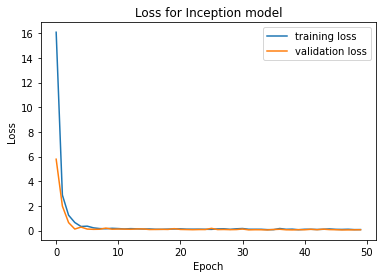

In [64]:
plt.figure()
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.title(f"Loss for Inception model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

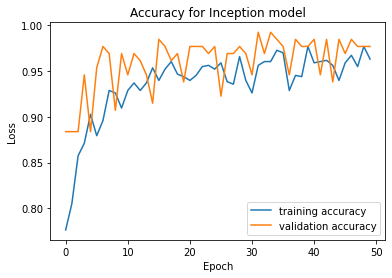

In [65]:
plt.figure()
plt.plot(history.history["acc"], label="training accuracy")
plt.plot(history.history["val_acc"], label="validation accuracy")
plt.title(f"Accuracy for Inception model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()